In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch.nn as nn
import torch.nn.functional as functional
from torch.autograd import Variable

# Read data

In [59]:
x_train = pd.read_csv('../../data/input_formated/nouser/x_train.csv').iloc[:, 1:]
y_train = pd.read_csv('../../data/input_formated/nouser/y_train.csv').iloc[:, 1:]

In [58]:
x_test = pd.read_csv('../../data/input_formated/nouser/x_test.csv').iloc[:, 1:]
y_test = pd.read_csv('../../data/input_formated/nouser/y_test.csv').iloc[:, 1:]

In [66]:
x_data = np.array(x_train.iloc[:, 2:], dtype = np.float32)
y_data = np.array(y_train.iloc[:, 1], dtype=np.float32).reshape((-1, 1))

In [65]:
x_testdata = np.array(x_test.iloc[:, 2:], dtype = np.float32)
y_testdata = np.array(y_test.iloc[:, 1], dtype=np.float32).reshape((-1, 1))

# ANN

In [43]:
def rmse(y, y_hat):
    """Compute root mean squared error"""
    return torch.sqrt(torch.mean((y - y_hat).pow(2)))

In [74]:
class ANN_1input(nn.Module):
    def __init__(self, input_0_size, hidden_size, output_size):
        super(ANN_1input, self).__init__()
        self.fc0 = nn.Linear(input_0_size, hidden_size) 
        self.activate0 = nn.Sigmoid()
        self.fc = nn.Linear(hidden_size, output_size)
        self.bn = nn.BatchNorm1d(output_size, output_size)
        self.activate = nn.Sigmoid()
        
        
    def forward(self, x):
        h = self.activate0(self.fc0(x))
        return self.activate(self.bn(self.fc(h)))

In [44]:
# Neural Network Model (1 hidden layer)
class ANN_1hidden(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANN_1hidden, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.activate = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.activate(out)
        out = self.fc2(out)
        return out

In [72]:
def train(x_data, y_data, learning_rate, num_epochs, check_point, model_save= None):
	n = int(0.8 * len(x_data))
	x_train, y_train = x_data[:n,:], y_data[:n, :]
	x_val, y_val = x_data[n:, :], y_data[n:, :]
	
	model = ANN_1input(x_train.shape[1], 10, y_train.shape[1])
    
	# Loss and Optimizer
	criterion = nn.MSELoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
	train_loss_list, val_loss_list = [], []

	#early stopping
	max_patience = 100
	patience = max_patience
	best_val = None
	
	# Train the Model 
	for epoch in range(num_epochs):
		# Convert numpy array to torch Variable
		inputs = Variable(torch.from_numpy(x_train))
		targets = Variable(torch.from_numpy(y_train), requires_grad = False)

		# Forward + Backward + Optimize
		optimizer.zero_grad()  
		outputs = model(inputs)
		
		train_loss = criterion(outputs, targets)
		train_loss_list.append(train_loss.data[0])
		
		#validate
		inputs = Variable(torch.from_numpy(x_val))
		targets = Variable(torch.from_numpy(y_val), requires_grad = False)
		outputs = model(inputs)   
		val_loss = criterion(outputs, targets)
		val_loss_list.append(val_loss.data[0])
		
		#optimize
		train_loss.backward()
		optimizer.step()
		
		if (epoch == 0) or ((epoch+1) % check_point == 0) or (epoch == num_epochs-1):
			print ('Epoch [%d/%d], Training Loss: %.4f, Validating Loss: %.4f' 
				   %(epoch+1, num_epochs, train_loss.data[0], val_loss.data[0]))
			if model_save is not None:
				torch.save(model, '%s/%d.pth' % (model_save, epoch+1))

		if (best_val is None) or ((best_val is not None) and (val_loss < best_val)) :
			best_val = val_loss
			patience = max_patience
		else:
			patience -= 1
		if patience == 0:
			print 'Early stopping at %d' % epoch
			break
		

	# Plot the graph
	print 'Plot graph from epoch 10th'
	plt.plot(range(len(train_loss_list))[10:], train_loss_list[10:], label='train')
	plt.plot(range(len(train_loss_list))[10:], val_loss_list[10:], label = 'validate')
	plt.legend()
	plt.show()
	return model

Epoch [1/500], Training Loss: 1.2617, Validating Loss: 1.2595
Epoch [100/500], Training Loss: 0.0486, Validating Loss: 0.0486
Epoch [200/500], Training Loss: 0.0482, Validating Loss: 0.0481
Epoch [300/500], Training Loss: 0.0481, Validating Loss: 0.0480
Epoch [400/500], Training Loss: 0.0481, Validating Loss: 0.0480
Epoch [500/500], Training Loss: 0.0481, Validating Loss: 0.0480
Plot graph from epoch 10th


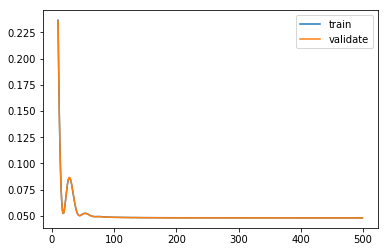

In [67]:
model = train(x_data, y_data, learning_rate = 0.01, num_epochs= 500, check_point = 100)

In [69]:
inputs = Variable(torch.from_numpy(x_data))
targets = Variable(torch.from_numpy(y_data[:, 0] * 5), requires_grad = False)
outputs = Variable(model(inputs).data[:,0] * 5)
print rmse(outputs, targets).sum()

Variable containing:
 1.0963
[torch.FloatTensor of size 1]



In [88]:
inputs = Variable(torch.from_numpy(x_testdata))
targets = Variable(torch.from_numpy(y_testdata[:, 0] * 5), requires_grad = False)
outputs = Variable(model(inputs).data[:,0] * 5)
print rmse(outputs, targets).sum()

Variable containing:
 1.0783
[torch.FloatTensor of size 1]



Epoch [1/500], Training Loss: 0.0970, Validating Loss: 0.0966
Epoch [100/500], Training Loss: 0.0500, Validating Loss: 0.0498
Epoch [200/500], Training Loss: 0.0475, Validating Loss: 0.0475
Epoch [300/500], Training Loss: 0.0469, Validating Loss: 0.0468
Epoch [400/500], Training Loss: 0.0466, Validating Loss: 0.0465
Epoch [500/500], Training Loss: 0.0464, Validating Loss: 0.0464
Plot graph from epoch 10th


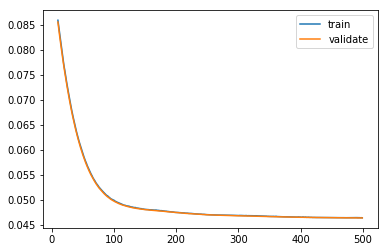

In [75]:
model = train(x_data, y_data, learning_rate = 0.01, num_epochs= 500, check_point = 100)

## Test

In [83]:
def test(x, y):
    inputs = Variable(torch.from_numpy(np.array(x, dtype = np.float32)))
    outputs = model(inputs).data[:,0]
    tmp = y
    tmp['output'] = outputs
    target = np.array(tmp.groupby('movie_id')['rating'].mean().reset_index(), dtype = np.float32)[:, 1].reshape((-1, 1))
    output = np.array(tmp.groupby(['movie_id'])['output'].mean().reset_index(), dtype = np.float32)[: ,1].reshape((-1,1))
    return np.mean(np.sqrt((target - output) * (target - output)))

In [86]:
test(x_train.iloc[:, 2:], y_train)

0.10472051

In [87]:
test(x_test.iloc[:, 2:], y_test)

0.10865084